# Writeup - Advanced Lane Finding

Welcome to my writeup on a pipeline to identify the lane boundaries in a video. This notebook contains both discussion and source code for each step.

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  Examples of the output from each stage of your pipeline in the folder called `ouput_images`.

In [1]:
# Importing useful libraries
%matplotlib inline
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the cell below.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [2]:
def points_for_calibration(images_pattern='camera_cal/calibration*.jpg', nx=9, ny=6):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for name in tqdm(glob.glob(images_pattern)):
        # Convert to grayscale
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, append points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. The calibration and distortion coefficients are saved as pickle files for later use.

In [3]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

objpoints, imgpoints = points_for_calibration()

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration.p", "wb"))

100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

In [4]:
def display_images(img1, img2, title1='Original image', 
                   title2='Modified image', filename=None, cmap=None):
    '''
    Utility function to display two images side by side.
    '''
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

    if filename:
        plt.savefig(filename)

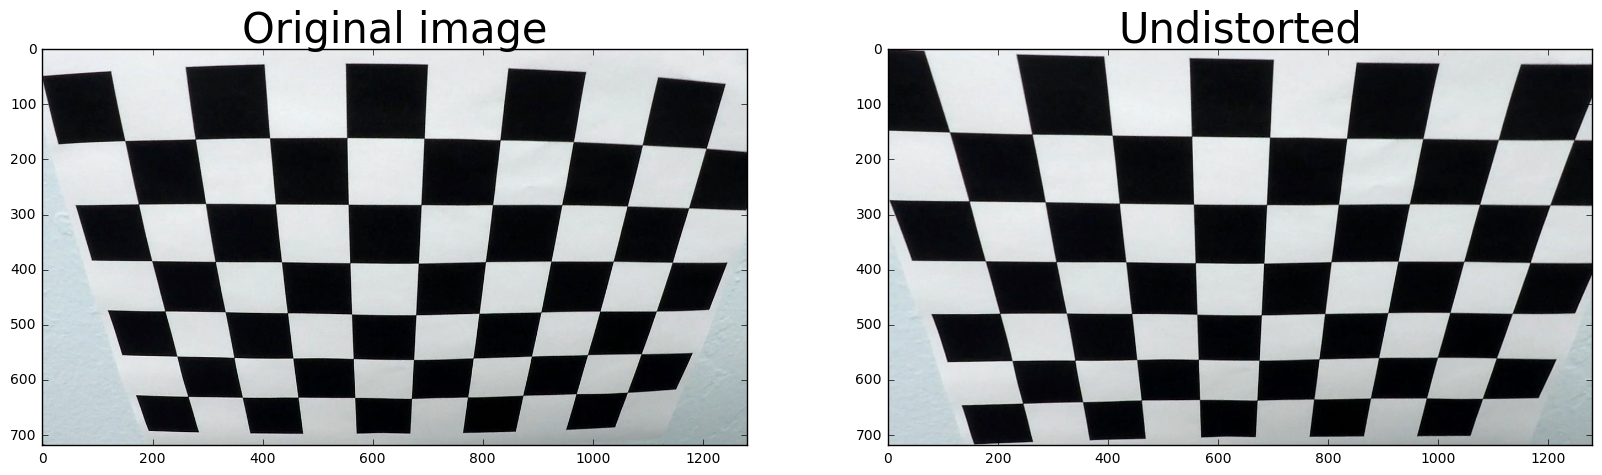

In [5]:
img = cv2.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
display_images(img, undistorted, title2='Undistorted',
               filename='output_images/original_undistorted.png')

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
Once you have the camera calibration and distortion coefficients, obtaining a distortion-corrected image is very simple: we just have to use the `cv2.undistort` function.

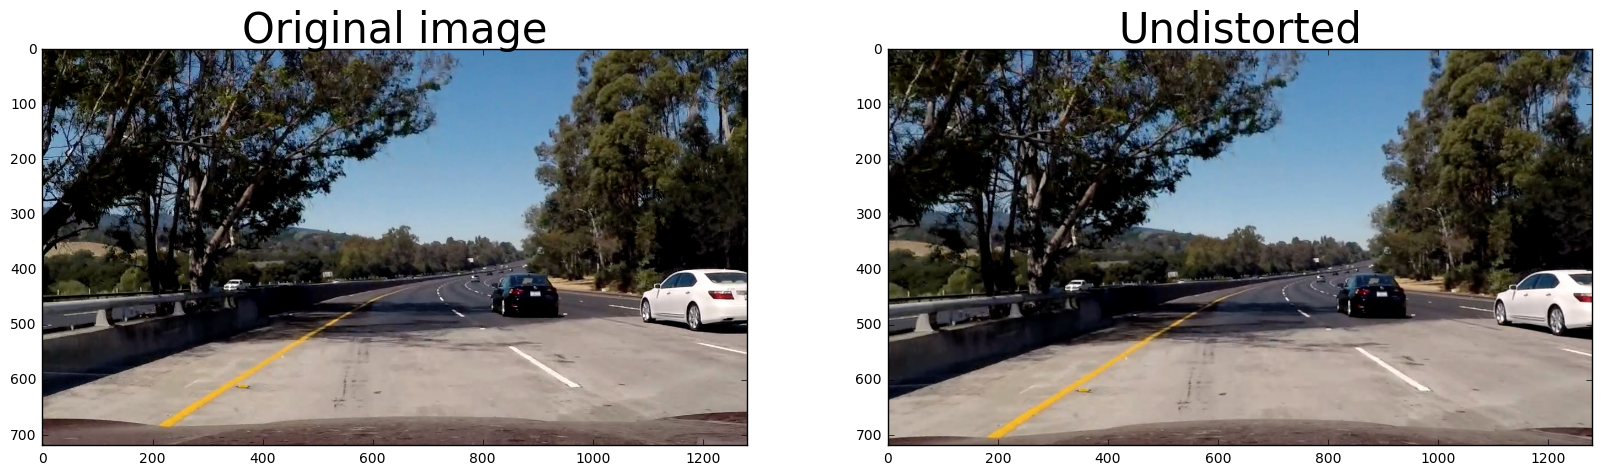

In [6]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
display_images(img, undistorted, title2='Undistorted',
               filename='output_images/test_original_undistorted.png')

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color, gradient (direction and magnitude) thresholds and [morphological transformations](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) to generate a binary image. The threshold functions as follows:

In [78]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    Applies Sobel kernel threshold to an image.
    '''
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        deriv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        deriv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    deriv = np.absolute(deriv)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    deriv = ((deriv / np.max(deriv)) * 255).astype(np.uint8)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(deriv)
    grad_binary[(deriv > thresh[0]) & (deriv < thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Applies gradient magnitude threshold to an image.
    '''
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    mag = np.sqrt((np.square(sobelx) + np.square(sobely)))
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    mag = ((mag / np.max(mag)) * 255).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag > mag_thresh[0]) & (mag < mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Applies gradient direction threshold to an image.
    '''
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return dir_binary

def color_threshold(img):
    '''
    Applies color threshold to an image, using RGB and HLS colorspaces.
    '''
    
    r_channel = img[:,:,0]
    
    # 1) Convert to HLS colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # 5) Create a binary mask where color thresholds are met
    binary = np.zeros_like(s_channel)
    binary[(h_channel > 15) & (h_channel < 100) & (s_channel > 120)] = 1
    binary[(r_channel > 220) & (r_channel < 255)] = 1
    
    return binary

def binary_image(img):
    '''
    Combine all threshold methods and morphological transformations
    to generate a binary image.
    '''
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10,150))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(10,150))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30,100))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    color_binary = color_threshold(img)

    # combine thresholds
    binary = np.zeros_like(color_binary)
    binary[(gradx == 1) & (grady == 1) | (color_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # morphological transformations
    kernel = np.ones((3,3),np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=2)
    binary = cv2.erode(binary, kernel, iterations=3)
    #binary = cv2.dilate(binary, kernel, iterations=2)
    return binary

Here's an example of my output for this step. We can see that the morphological transformations do a good job in removing "noise" and making lane lines more clear. We define a function `binary_image` to reuse this strategy in the pipeline.

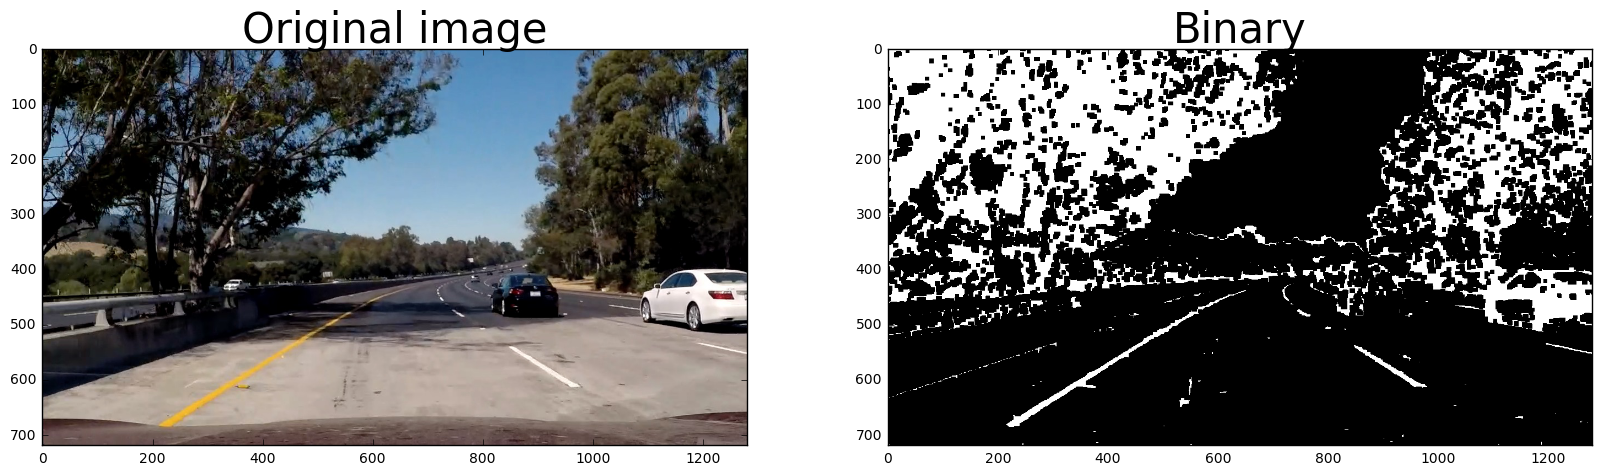

In [79]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = binary_image(img)
display_images(img, binary, cmap='gray', title2='Binary',
               filename='output_images/original_binary.png')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `birds_eye()` defined below.  The `birds_eye()` function takes as inputs an image (`img`), as well as the camera matrix (`mtx`) and distortion coefficients (`dist`) points.  I chose birds_eye hardcode the source and destination points in the following manner:

```
src = np.array([[img.shape[1]/6 - 10, img.shape[0]],
                [img.shape[1]/2 - 48, img.shape[0]/1.6],
                [img.shape[1]/2 + 50, img.shape[0]/1.6],
                [img.shape[1] - 160, img.shape[0]]], np.float32)
    
dst = np.array([[src[0,0] + 120, img.shape[0]],
                    [src[0,0] + 120, 0],
                    [src[-1,0] - 120, 0],
                    [src[-1,0] - 120, img.shape[0]]], np.float32)
```

In [63]:
def birds_eye(img, mtx, dist, show_lines=False):
    
    # 1) Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx, dist)
    
    src = np.array([[img.shape[1]/6 - 10, img.shape[0]],
                [img.shape[1]/2 - 48, img.shape[0]/1.6],
                [img.shape[1]/2 + 50, img.shape[0]/1.6],
                [img.shape[1] - 160, img.shape[0]]], np.float32)
    
    dst = np.array([[src[0,0] + 100, img.shape[0]],
                    [src[0,0] + 100, 0],
                    [src[-1,0] - 100, 0],
                    [src[-1,0] - 100, img.shape[0]]], np.float32)
    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted, M, undistorted.shape[:2][::-1])
    
    if show_lines:
        if len(warped.shape) == 2:
            warped = np.dstack((warped, warped, warped))

        if np.max(warped) > 1:
            max_color = 255
        else:
            max_color = 1

        cv2.polylines(img, np.array([src], np.int32), True, (max_color,0,0), 3)
        cv2.polylines(warped, np.array([dst], np.int32), True, (max_color,0,0), 3)
    
    return warped, M

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

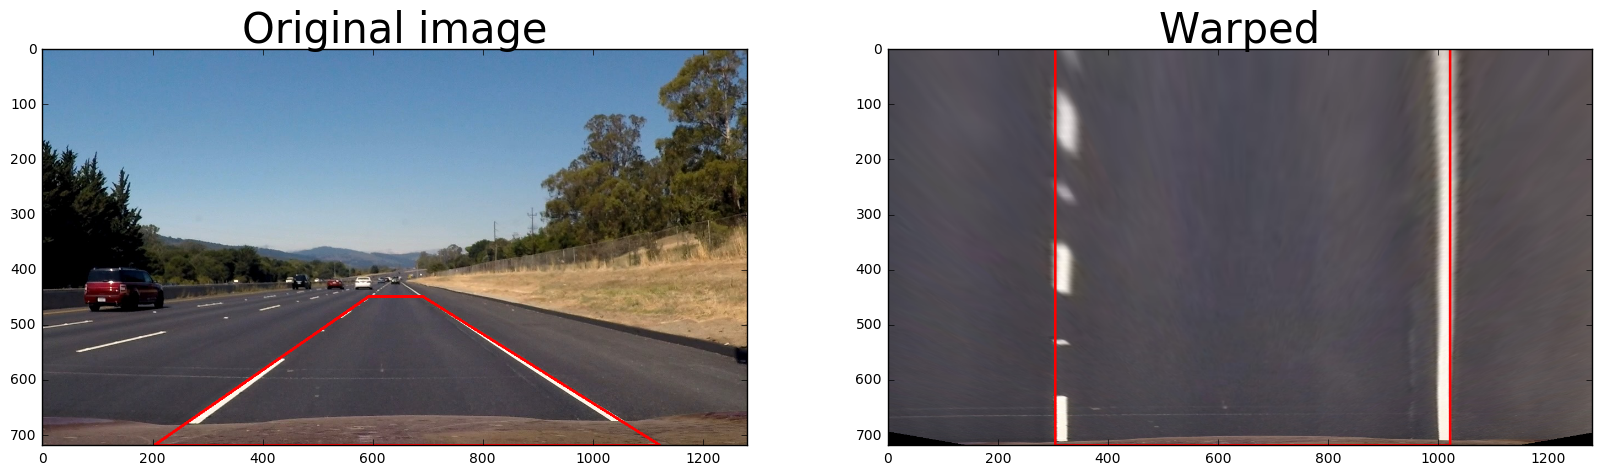

In [64]:
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, _ = birds_eye(img, mtx, dist, show_lines=True)
display_images(img, warped, title2='Warped',
               filename='output_images/birds_eye.png')

Let's see how this works on a binary image.

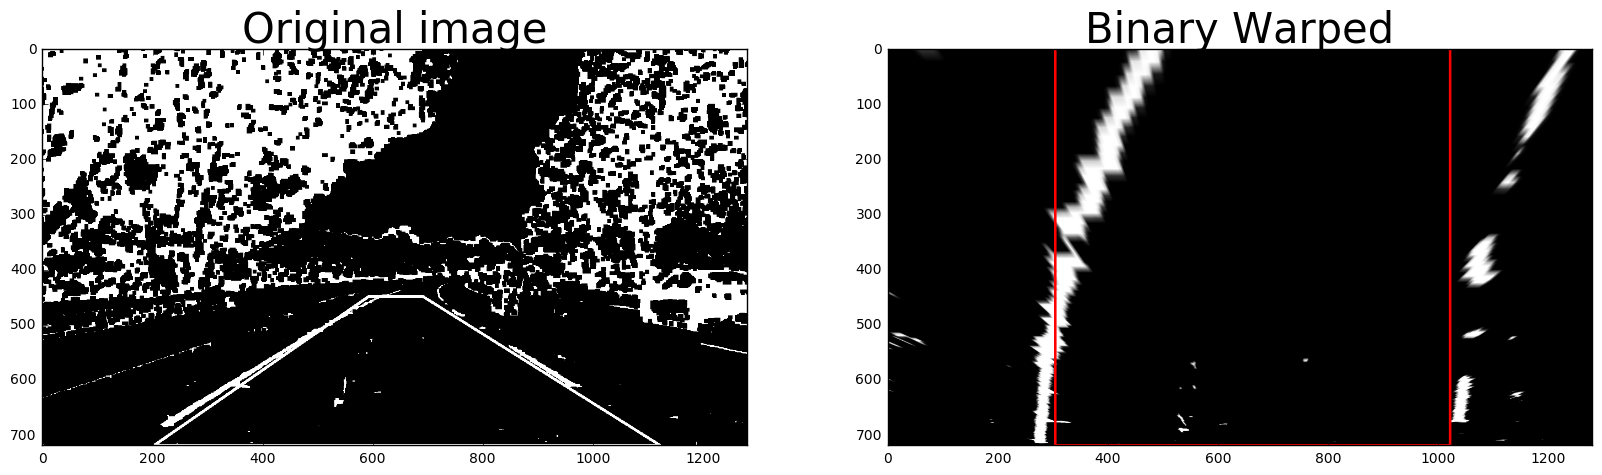

In [80]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = binary_image(img)
binary_warped, _ = birds_eye(binary, mtx, dist, show_lines=True)
display_images(binary, binary_warped, cmap='gray', title2='Binary Warped',
               filename='output_images/birds_eye_binary.png')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The strategy here is to fit the lane lines with second order polynomials. The implementation consists of the following steps:

* Find the initial x coordinates for the lane bases using an image histogram (see `lane_bases` function)
* Search lane pixels using sliding windows (see `lane_polyfit` function).
* Apply some constraints to the lanes for sanity check (see `apply_constraints` function)
* Create an image with a overlay indicating the lane boundaries (see `lane_image` function)

All these steps are implemented in the next cell.

In [88]:
def lane_bases(binary_image):
    '''
    Find best guesses for lane bases using a histogram.
    '''

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_image[int(binary_image.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def apply_constraints(left_fit, right_fit, 
                      left_lane_inds, right_lane_inds, 
                      max_x, max_y):
    '''
    Checks and adjusts lane lines according to road geometry constraints.
    '''
    
    left_base = left_fit[0]*max_y**2 + left_fit[1]*max_y + left_fit[2]
    right_base = right_fit[0]*max_y**2 + right_fit[1]*max_y + right_fit[2]
    
    # Lanes should not have inverted curvatures
    if left_fit[0] < 0 and right_fit[0] > 0 or left_fit[0] > 0 and right_fit[0] < 0:
        #print('Lane detection discarded: coefficients with inverted signals')
        
        # Choose the lane with more pixels as the fit for the two lanes
        if len(left_lane_inds) > len(right_lane_inds):
            right_fit[:2] = left_fit[:2]
            right_fit[-1] = right_base - right_fit[0]*(max_y)**2 - right_fit[1]*max_y
        else:
            left_fit[:2] = right_fit[:2]
            left_fit[-1] = left_base - left_fit[0]*(max_y)**2 - left_fit[1]*max_y
    
    lane_width = 750
    max_lane_width = 850
    min_lane_width = 650
    
    # Lanes width should respect a range of values 
    if right_base - left_base > max_lane_width or right_base - left_base < min_lane_width:
        #print('Lane detection discarded: lane width={} pixels'.format(right_base - left_base))
        
        # Choose the lane nearest to the image center as the fit for the two lanes
        if abs(left_base - max_x/2) < abs(right_base - max_x/2):
            right_fit[:2] = left_fit[:2]
            right_fit[-1] = (left_base + lane_width) - right_fit[0]*(max_y)**2 - right_fit[1]*max_y
        else:
            left_fit[:2] = right_fit[:2]
            left_fit[-1] = (right_base - lane_width) - left_fit[0]*(max_y)**2 - left_fit[1]*max_y
    
    return left_fit, right_fit

def lane_polyfit(binary_image, nwindows=9, margin=100, minpix=50, left_fit=None, right_fit=None):
    '''
    Fits one second order polynomial for each lane line.  
    '''
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Optimization: if a previous left and right fits are passed as parameters, 
    # the function skips the sliding window search
    if left_fit is not None and right_fit is not None:
    #and left_fit[0] != right_fit[0] and left_fit[1] != right_fit[1]:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    else:
        #print("using windows to search lane pixels...")
        # Current positions to be updated for each window
        left_base, right_base = lane_bases(binary_image)
        leftx_current, rightx_current = left_base, right_base
        
        # Set height of windows
        window_height = np.int(binary_image.shape[0]/nwindows)
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_image.shape[0] - (window+1)*window_height
            win_y_high = binary_image.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = None
    right_fit = None
    
    # Fit a second order polynomial to each
    if len(lefty) > 0 and len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(righty) > 0 and len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    if left_fit is None:
        left_fit = right_fit
    if right_fit is None:
        right_fit = left_fit
    
    # Perform sanity checks
    left_fit, right_fit = apply_constraints(left_fit, right_fit, 
                                            left_lane_inds, right_lane_inds,
                                            binary_image.shape[1] - 1,
                                            binary_image.shape[0] - 1)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def lane_image(binary_image, nwindows=4, margin=100, minpix=50, 
               left_fit=None, right_fit=None, show_lane_pixels=False):
    '''
    Creates an image with lane boundaries marked.
    '''
    
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = lane_polyfit(binary_image, 
                                                                        nwindows=6, 
                                                                        margin=100, 
                                                                        minpix=50, 
                                                                        left_fit=left_fit, 
                                                                        right_fit=right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if show_lane_pixels:    
        # Create an image to draw on and an image to show the selection window
        out_img = np.zeros_like(np.dstack((binary_image, binary_image, binary_image)))#*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
    else:
        window_img = np.zeros_like(np.dstack((binary_image, binary_image, binary_image)))

    # Generate a polygon to illustrate the lane boundaries
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    line_pts = np.hstack((left_line_window2, right_line_window1))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,1,0))
    
    if show_lane_pixels:
        result = cv2.addWeighted(out_img, 1, window_img, 0.4, 0)
        result[result > 1.] = 1.
    else:
        result = window_img
    
    return result, left_fit, right_fit

This is an example of lane detection applied to a binary warped image:

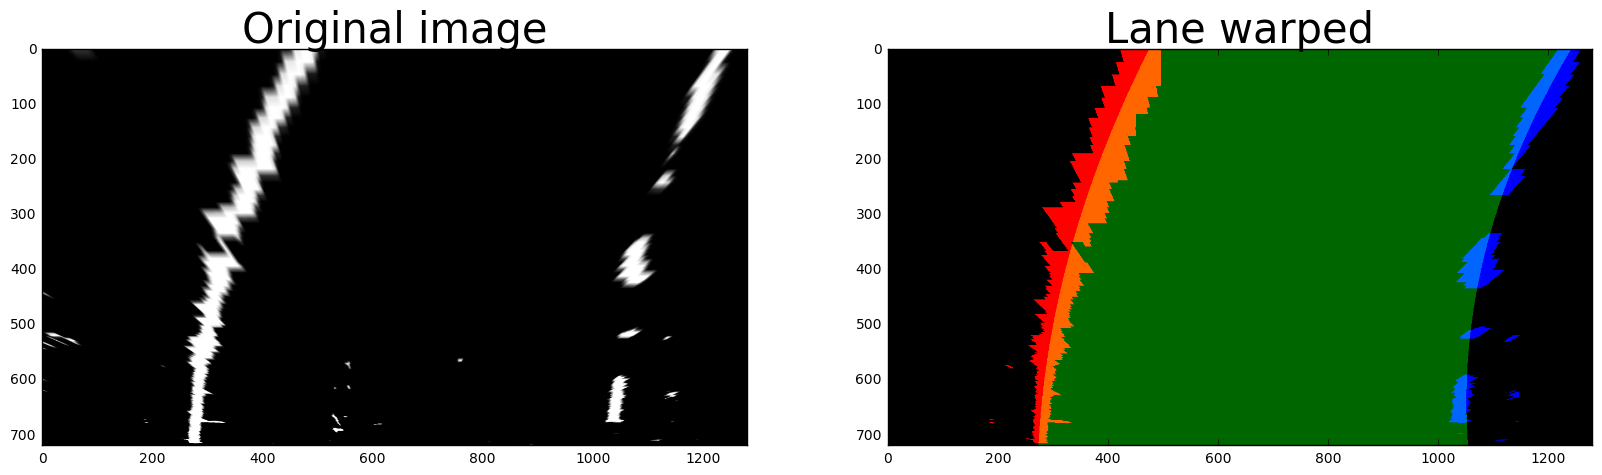

In [81]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = binary_image(img)
binary_warped, _ = birds_eye(binary, mtx, dist)
        
lane, left_fit, right_fit = lane_image(binary_warped, show_lane_pixels=True)
display_images(binary_warped, lane, cmap='gray', title2='Lane warped',
               filename='output_images/lane_warped.png')

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In this implementation we use the radius of curvature formula defined in [this tutorial](http://www.intmath.com/applications-differentiation/8-radius-curvature.php).

In [28]:
def curvature(left_fit, right_fit, x_range=1280, y_range=720, 
              xm_per_pix=3.7/700, ym_per_pix = 30/720):
    '''
    Calculate lane lines curvature and vehicle shift from the lane center.
    '''
    
    ploty = np.linspace(0, y_range-1, num=y_range)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    camera_center = x_range/2
    lane_center = (right_fitx[-1] + left_fitx[-1])/2
    # shift in meters
    shift = (lane_center - camera_center) * xm_per_pix 

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = y_range-1
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, shift

We can now calculate the radius of curvature and shift for the last example image.

In [82]:
left_curverad, right_curverad, shift = curvature(left_fit, right_fit)
# Now our radius of curvature is in meters
print('Cuvature left: {:.1f}m /'.format(left_curverad), 
      'Curvature right: {:.1f}m'.format(right_curverad),
      'Center shift: {:.1f}m'.format(shift))
# Example values: 632.1 m    626.2 m

Cuvature left: 520.8m / Curvature right: 352.4m Center shift: 0.1m


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented all the pipeline in the function `find_lane()` below. Besides the lane boundaries, we plot the radius of curvature (average of left and right line radius), shift from lane center and warped binary image (useful for debugging).

In [31]:
def find_lane(img, mtx, dist, left_fit=None, right_fit=None):
    '''
    Returns an image with lane boundaries, radius of curvature and shift from lane center.
    '''
    
    binary = binary_image(img)
    binary_warped, M = birds_eye(binary, mtx, dist)
    lane, left_fit, right_fit = lane_image(binary_warped, left_fit=left_fit, right_fit=right_fit)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(lane, np.linalg.inv(M), (img.shape[1], img.shape[0]))
    
    if np.max(img) > 1:
        img = img/255.
        
    result = cv2.addWeighted(img.astype(np.float64), 1., newwarp, 0.3, 0)
    result[result > 1.] = 1.
    
    binary_small = cv2.resize(binary_warped, None, fx=.3, fy=.3, interpolation = cv2.INTER_CUBIC)
    binary_small = np.dstack((binary_small, binary_small, binary_small))
    result[:binary_small.shape[0], result.shape[1] - binary_small.shape[1]:] = binary_small
    
    left_curverad, right_curverad, shift = curvature(left_fit, right_fit)
    mean_curvature = np.mean((left_curverad, right_curverad))
    
    cv2.fillConvexPoly(result,np.array([(0,0),(0, binary_small.shape[0]-1),
                                        (result.shape[1] - binary_small.shape[1],
                                         binary_small.shape[0]-1),
                                        (result.shape[1] - binary_small.shape[1],0)]),(0,0,0)) 
    
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(result, 'Curvature: {:.01f}m'.format(mean_curvature), (50,80), font, 4, (1,1,1), 3)
    cv2.putText(result, 'Center shift: {:.01f}m'.format(shift), (50,150), font, 4, (1,1,1), 3)
    
    # Combine the result with the original image
    return result, left_fit, right_fit

We now can see all steps applied to a test image.

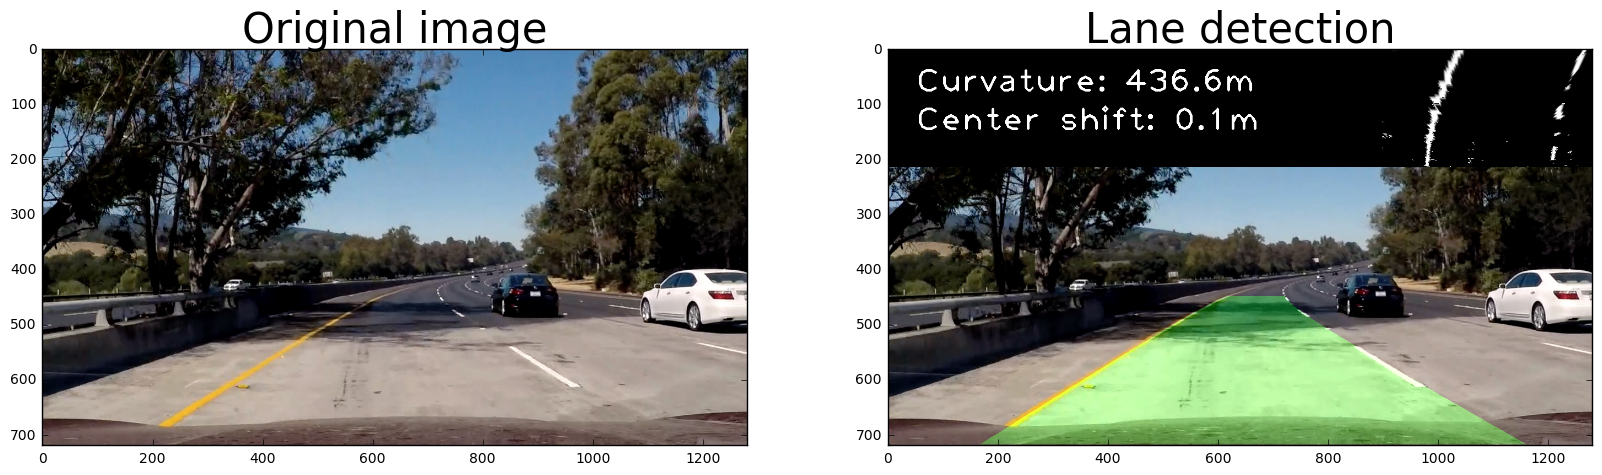

In [83]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lane, lf, rf = find_lane(img, mtx, dist)
display_images(img, lane, title2='Lane detection',
               filename='output_images/lane.png')

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

In this step we just apply the pipeline for each video frame and create an [output video](https://github.com/thefonseca/car-nanodegree/tree/master/CarND-Advanced-Lane-Lines/output.mp4) (with moviepy). We use a moving average to smooth the coefficients using the last `n` frames.

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle

In [71]:
# load calibration and distortion coefficients
with (open("camera_cal/calibration.p", "rb")) as openfile:
    dist_pickle = pickle.load(openfile)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

# some globals to keep data from last frames 
left_fit = None
right_fit = None
left_fits = []
right_fits = []

def moving_average(a, n=20):
    '''
    Moving average of last n array elements.
    '''
    
    if len(a) == 0:
        return None
    
    if len(a) < n:
        return a[-1]
    
    ret = np.cumsum(a, axis=0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n-1:] / n)[-1]

def smooth_fit(left_fit, right_fit, left_fits, right_fits):
    '''
    Returns smooth (moving average) values for left and right 
    lines coefficients.
    '''
    
    left_fits.append(left_fit)
    right_fits.append(right_fit)
        
    return (moving_average(np.array(left_fits)), 
            moving_average(np.array(right_fits)))

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    
    global left_fit
    global right_fit
    global left_fits
    global right_fits
    
    frame, left_fit, right_fit = find_lane(image, mtx, dist, 
                                           left_fit=left_fit, 
                                           right_fit=right_fit)
    # smooth coefficients
    left_fit, right_fit = smooth_fit(left_fit, right_fit, 
                                     left_fits, right_fits)
    last_frame = frame*255
    return last_frame

Finally, it's time to test the pipeline in the project video!

In [86]:
clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('output.mp4', audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [08:25<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 28min 3s, sys: 4min 25s, total: 32min 28s
Wall time: 8min 26s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

While the pipeline seems to work well for the `project_video.mp4` example, the solution "overfits" to this set of frames and cannot generalize well for the other challenge videos.

The critical part of the pipeline is the thresholding algorithm. If the binary images do not show enough lane markings, we cannot properly detect lane boundaries. The algorithm seems to be very brittle and cannot deal with a high variation of lighting and colors, and probably will fail in different weather conditions. Maybe some kind of image normalization would make this pipeline more robust.

Another major problem is the performance of the algorithm. The pipeline can process about 3 frames per second, which is not viable for real world application. This problem may be solved if we use GPU acceleration, since [opencv supports CUDA](http://opencv.org/platforms/cuda.html) with performance gains up to 30x for primitive image operations.

---

That's it! Thanks for reading! &#128663;